In [3]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import os
import pandas as pd

load_dotenv()
engine = create_engine(os.getenv("DATABASE_URL"))

df = pd.read_sql("SELECT * FROM hpce.churn_model_dataset", engine)
df.head()

,customer_id,recency_days,f_30,m_30,views_30,events_30,churn_90d
0,b6bc0a0984212a4c64f88c94d0007c07,-255.0,2.0,63.50,4.0,6.0,0
1,b46ec2f0ca57df3f1300fd71d9b3ac50,-38.0,2.0,215.56,2.0,4.0,1
2,97017b21b91c3f6d661ccaceee407af9,204.0,0.0,0.00,0.0,0.0,1
3,404077a979fd9f71e8faf8931fae497c,-273.0,2.0,296.40,0.0,0.0,0
4,713d876c66755a8af5d2689433f37498,45.0,0.0,0.00,0.0,0.0,1


In [4]:
from sklearn.model_selection import train_test_split

X = df[["recency_days", "f_30", "m_30", "views_30", "events_30"]]
y = df["churn_90d"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
from xgboost import XGBClassifier

model = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [6]:
from sklearn.metrics import roc_auc_score, classification_report

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))

AUC: 0.9999844968748703
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3612
           1       1.00      1.00      1.00     16224

    accuracy                           1.00     19836
   macro avg       1.00      1.00      1.00     19836
weighted avg       1.00      1.00      1.00     19836



ExactExplainer explainer: 99179it [14:38, 112.65it/s]                                                                         


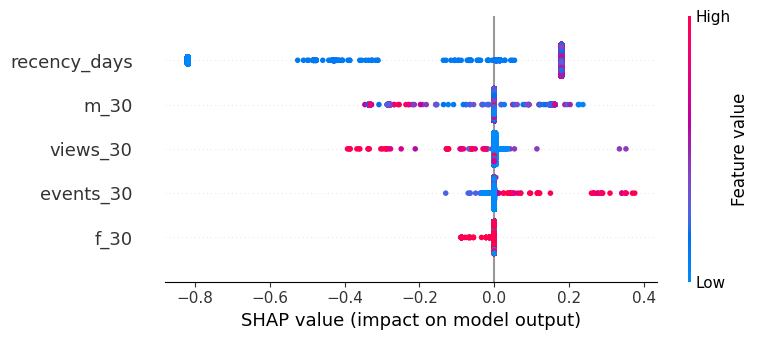

In [7]:
import shap

explainer = shap.Explainer(model.predict, X)   # no TreeExplainer here
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


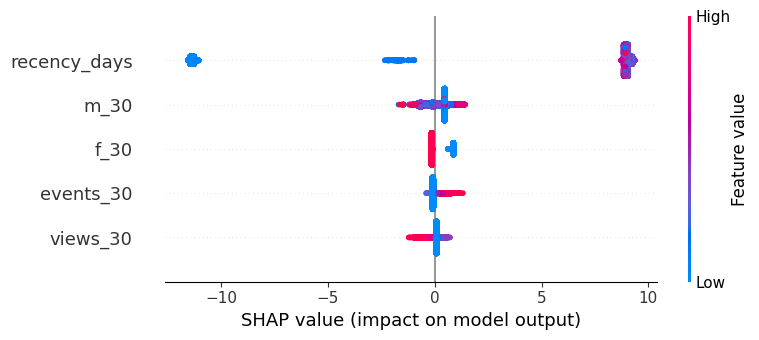

In [8]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [9]:
df["churn_probability"] = model.predict_proba(df[X.columns])[:,1]

df_predictions = df[["customer_id", "churn_probability"]]

df_predictions.to_sql(
    "customer_churn_scores",
    engine,
    schema="hpce",
    if_exists="replace",
    index=False
)

178